# Exchange economy

Here you learn how to solve a **simple exchange economy**. Either by

1. Using a auction-like algorithm
1. Using a root-finder

On top of solving for the **Walras-equilibrium**, you will learn to numerically find the **contract curve**, and solve the **planner problem** and **dictator problems**.

Additionally, you will learn how to **structure an economic model in a class**.

**Table of contents**<a id='toc0_'></a>    
- 1. [Model](#toc1_)    
- 2. [Setup](#toc2_)    
- 3. [Walras equilibrium](#toc3_)    
  - 3.1. [Root-finding](#toc3_1_)    
- 4. [Any final questions at this stage?](#toc4_)    
- 5. [Social planner](#toc5_)    
- 6. [Dictator A](#toc6_)    
- 7. [Random endowments](#toc7_)    
- 8. [Any final questions?](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
from ExchangeEconomyModel import ExchangeEconomyModelClass

## 1. <a id='toc1_'></a>[Model](#toc0_)

We consider an **exchange economy** with:

- Two consumers, A and B.
- Two goods, $x_{1}$ and $x_{2}$. 

**Endowments:**

* The initial endowments are $\omega_{1}^{A}\geq0$ and $\omega_{2}^{A}\geq0$. 
* The total endowment of each good is always one, such that $\omega_{1}^{B} = 1-\omega_{1}^{A}$ and $\omega_{2}^{B} = 1-\omega_{2}^{A}$.
* We define the vectors $\boldsymbol{\omega}^{A}$ = $(\omega_{1}^{A},\omega_{2}^{A})$, and $\boldsymbol{\omega}^{B}=(\omega_{1}^{B},\omega_{2}^{B})$.

**Prices:** $\boldsymbol{p}=(p_{1},p_{2})$ with numeraire $p_2 = 1$.

**Utility functions**:

$$
\begin{aligned}
u^{A}(x_{1},x_{2})	&= x_{1}^{\alpha}x_{2}^{1-\alpha},\,\,\,\alpha\in(0,1) \\
u^{B}(x_{1},x_{2})	&= x_{1}^{\beta}x_{2}^{1-\beta},\,\,\,\beta\in(0,1) \\
\end{aligned}
$$

**Demand functions**:

$$
\begin{aligned}
x_{1}^{A\star}(\boldsymbol{p},\boldsymbol{\omega}^{A}) &= \alpha\frac{p_{1}\omega_{1}^{A}+p_{2}\omega_{2}^{A}}{p_{1}} \\
x_{2}^{A\star}(\boldsymbol{p},\boldsymbol{\omega}^{A}) &= (1-\alpha)\frac{p_{1}\omega_{1}^{A}+p_{2}\omega_{2}^{A}}{p_{2}} \\
x_{1}^{B\star}(\boldsymbol{p},\boldsymbol{\omega}^{B}) &= \beta\frac{p_{1}\omega_{1}^{B}+p_{2}\omega_{2}^{B}}{p_{1}} \\
x_{2}^{B\star}(\boldsymbol{p},\boldsymbol{\omega}^{B}) &= (1-\beta)\frac{p_{1}\omega_{1}^{B}+p_{2}\omega_{2}^{B}}{p_{2}} \\
\end{aligned}
$$

**Walras equilibrium**: Market clearing requires demand = endowment (supply),

$$
\begin{aligned}
x_{1}^{A\star}(\boldsymbol{p},\boldsymbol{\omega}^{A})+x_{1}^{B\star}(\boldsymbol{p},\boldsymbol{\omega}^{B}) &= \omega_{1}^{A}+\omega_{1}^{B} \\
x_{2}^{A\star}(\boldsymbol{p},\boldsymbol{\omega}^{A})+x_{2}^{B\star}(\boldsymbol{p},\boldsymbol{\omega}^{B}) &= \omega_{2}^{A}+\omega_{2}^{B}
\end{aligned}
$$ 

## 2. <a id='toc2_'></a>[Setup](#toc0_)

In [4]:
model = ExchangeEconomyModelClass()

In [5]:
par = model.par
sol = model.sol
sim = model.sim

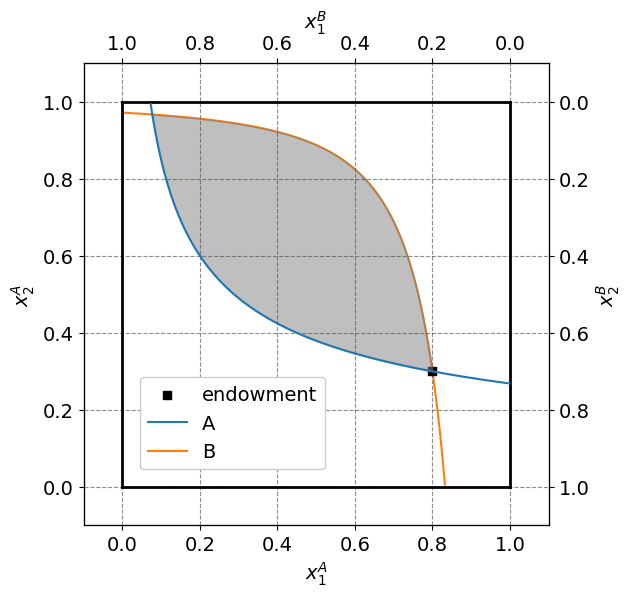

In [6]:
fig,ax_A,ax_B = model.create_edgeworthbox()
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')
model.indifference_curve_A(ax_A,par.w1A,par.w2A,color=colors[0],label='A')
model.indifference_curve_B(ax_B,1-par.w1A,1-par.w2A,color=colors[1],label='B')
model.plot_improvement_set(ax_A)
model.add_legend(ax_A,ax_B)

## 3. <a id='toc3_'></a>[Walras equilibrium](#toc0_)

The **excess demand** functions are:

$$
\begin{aligned}
\epsilon_{1}(\boldsymbol{p},\boldsymbol{\omega}) & =x_{1}^{A\star}(\boldsymbol{p},\boldsymbol{\omega}^{A})-\omega_{1}^{A}+x_{1}^{B\star}(\boldsymbol{p},\boldsymbol{\omega}^{B})-\omega_{1}^{B}\\
\epsilon_{2}(\boldsymbol{p},\boldsymbol{\omega}) & =x_{2}^{A\star}(\boldsymbol{p},\boldsymbol{\omega}^{A})-\omega_{2}^{A}+x_{2}^{B\star}(\boldsymbol{p},\boldsymbol{\omega}^{B})-\omega_{2}^{B}\\
\end{aligned}
$$

In equilibrium excess demand is 0.

**Walras' law** says $\epsilon_{1}=0\Rightarrow\epsilon_{2}=0$.

**Grid search:** Search price grid for lowest excess demand of good 1, $\epsilon_1$.

In [7]:
# a. number of grid points
N = 10

# b. grids
p1_grid =  0.5 + 2*np.linspace(0,1,N+1)
eps_grid = np.empty((2,N+1))

# c. evaluate and find minimum excess demand
min_eps1 = np.inf
min_eps = np.inf
p_guess = np.nan

for i,p1 in enumerate(p1_grid):

    eps_grid[:,i] = model.check_market_clearing(p1)
    print(f"p1 = {p1:.2f}, eps1 = {eps_grid[0,i]:7.4f}, eps2 = {eps_grid[1,i]:7.4f}")

    if np.abs(eps_grid[0,i]) < min_eps1:
        min_eps1 = np.abs(eps_grid[0,i])
        p_guess = p1

print(f"\nMinimum excess demand for good 1 is {min_eps1:.4f} at price p1 = {p_guess:.4f}")

p1 = 0.50, eps1 =  0.5333, eps2 = -0.2667
p1 = 0.70, eps1 =  0.2095, eps2 = -0.1467
p1 = 0.90, eps1 =  0.0296, eps2 = -0.0267
p1 = 1.10, eps1 = -0.0848, eps2 =  0.0933
p1 = 1.30, eps1 = -0.1641, eps2 =  0.2133
p1 = 1.50, eps1 = -0.2222, eps2 =  0.3333
p1 = 1.70, eps1 = -0.2667, eps2 =  0.4533
p1 = 1.90, eps1 = -0.3018, eps2 =  0.5733
p1 = 2.10, eps1 = -0.3302, eps2 =  0.6933
p1 = 2.30, eps1 = -0.3536, eps2 =  0.8133
p1 = 2.50, eps1 = -0.3733, eps2 =  0.9333

Minimum excess demand for good 1 is 0.0296 at price p1 = 0.9000


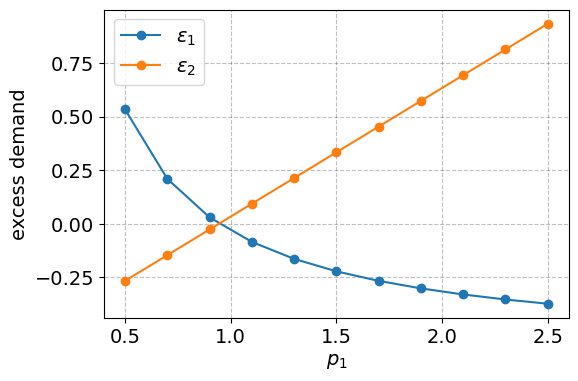

In [8]:
fig,ax = plt.subplots(figsize=(6,4))

ax.plot(p1_grid,eps_grid[0,:],'-o',label='$\\epsilon_1$')
ax.plot(p1_grid,eps_grid[1,:],'-o',label='$\\epsilon_2$')
ax.set_xlabel('$p_1$')
ax.set_ylabel('excess demand')
ax.legend();

**Find equilibrium price** using the following algorithm:

1. Gusss $p_1^0$ and set $k=0$.
2. Calculate $\epsilon_1$ using $p_1 = p_1^{k}$.
3. If $\epsilon_1<\tau$ stop.
4. Else $p_1^{k+1}=p_1^k + \nu \epsilon_1$.
5. Increment $k$ and go to 2.

where $\tau$ is a small number (tolerance).

**Intuition:** 
1. Think of an auction process where prices are called until market clear (fancy french name: tâtonnement)
1. Increase price if too much demand (positive excess demand)

In [9]:
model.solve_walras(p_guess=p_guess,print_output=True)

  0: p1 =   0.90000000 -> excess demand of good 1 ->     0.02962963, x1A =   0.37777778, x2A =   0.68000000, x1B =   0.65185185, x2B =   0.29333333
  1: p1 =   0.91481481 -> excess demand of good 1 ->     0.01943320, x1A =   0.37597841, x2A =   0.68790123, x1B =   0.64345479, x2B =   0.29432099
  2: p1 =   0.92453141 -> excess demand of good 1 ->     0.01292311, x1A =   0.37482957, x2A =   0.69308342, x1B =   0.63809354, x2B =   0.29496876
  3: p1 =   0.93099297 -> excess demand of good 1 ->     0.00866912, x1A =   0.37407886, x2A =   0.69652958, x1B =   0.63459025, x2B =   0.29539953
  4: p1 =   0.93532753 -> excess demand of good 1 ->     0.00584838, x1A =   0.37358109, x2A =   0.69884135, x1B =   0.63226729, x2B =   0.29568850
  5: p1 =   0.93825172 -> excess demand of good 1 ->     0.00396017, x1A =   0.37324787, x2A =   0.70040092, x1B =   0.63071230, x2B =   0.29588345
 10: p1 =   0.94353587 -> excess demand of good 1 ->     0.00057777, x1A =   0.37265098, x2A =   0.70321913, x1B

**Question I:** Does it work for all valus of $\nu$?

**Question II:** What could we alternatively have done?

Plot:

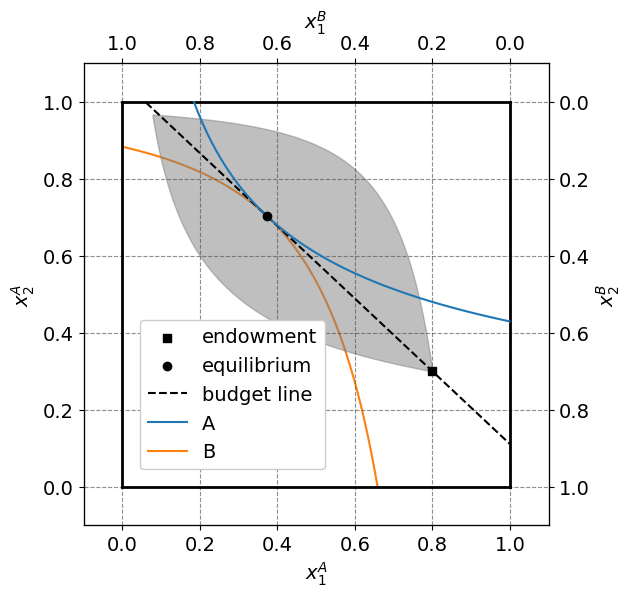

In [10]:
fig,ax_A,ax_B = model.create_edgeworthbox()

ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment',zorder=3)
ax_A.scatter(sol.xA[0],sol.xA[1],marker='o',color='black',label='equilibrium',zorder=3)

model.plot_budget_line(ax_A)
model.plot_improvement_set(ax_A)
model.indifference_curve_A(ax_A,sol.xA[0],sol.xA[1],color=colors[0],label='A')
model.indifference_curve_B(ax_B,1-sol.xA[0],1-sol.xA[1],color=colors[1],label='B')
model.add_legend(ax_A,ax_B)

### 3.1. <a id='toc3_1_'></a>[Root-finding](#toc0_)

**Find Walras-equilibrium with numerical root-finder:**

In [11]:
from scipy import optimize

# a. objective function
def obj(p1):
    eps = model.check_market_clearing(p1)
    return eps[0]

# b. find root
res = optimize.root_scalar(obj,bracket=[0.1,10],method='bisect')

# c. print
print(f'{sol.p1   = :12.8f}')
print(f'{res.root = :12.8f}')
print()
print(res)

sol.p1   =   0.94444443
res.root =   0.94444444

      converged: True
           flag: converged
 function_calls: 45
     iterations: 43
           root: 0.9444444444452189
         method: bisect


**Task:** Print how the guesses are changing when calling the root-finder.

## 4. <a id='toc4_'></a>[Any questions at this stage?](#toc0_)

**Socrative room:** PROGECON

## 5. <a id='toc5_'></a>[Social planner](#toc0_)

A utilitarian social planner would solve:

$$
\max_{(x_{1}^{A},x_{2}^{A})\in[0,1]\times[0,1]}u^{A}(x_{1}^{A},x_{2}^{A})+u^{B}(1-x_{1}^{A},1-x_{2}^{A})
$$

In [12]:
model.solve_social_planner()

Planner solution:
x1A =   0.33341166
x2A =   0.66658832
Utility of A:   0.52913367
Utility of B:   0.52913369


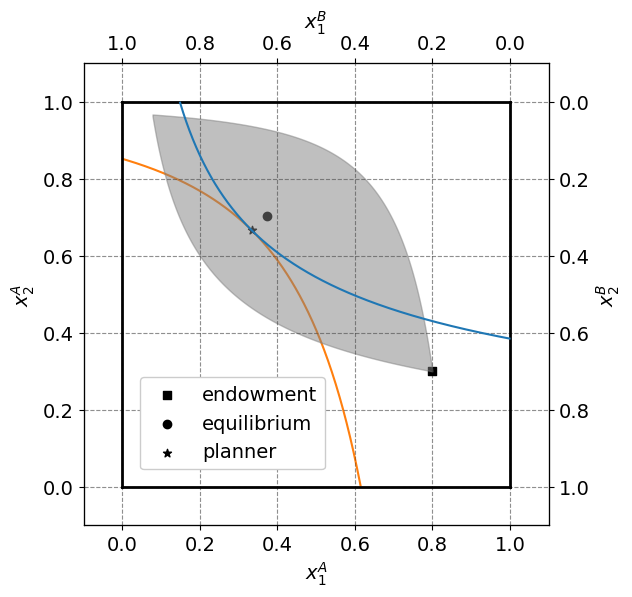

In [13]:
fig,ax_A,ax_B = model.create_edgeworthbox()
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')
ax_A.scatter(sol.xA[0],sol.xA[1],marker='o',color='black',label='equilibrium')
ax_A.scatter(sol.xA_planner[0],sol.xA_planner[1],marker='*',color='black',label='planner')

model.indifference_curve_A(ax_A,sol.xA_planner[0],sol.xA_planner[1],color=colors[0])
model.indifference_curve_B(ax_B,1-sol.xA_planner[0],1-sol.xA_planner[1],color=colors[1])
model.plot_improvement_set(ax_A)
model.add_legend(ax_A,ax_B)

What happens if the scale of the utility functions changes? E.g. if

$$
\begin{aligned}
u^{A}(x_{1},x_{2})	&= A x_{1}^{\alpha}x_{2}^{1-\alpha},\,\,\,\alpha\in(0,1) \\
u^{B}(x_{1},x_{2})	&= x_{1}^{\beta}x_{2}^{1-\beta},\,\,\,\beta\in(0,1) \\
\end{aligned}
$$

for some $A > 0$.

## 6. <a id='toc6_'></a>[Dictator A](#toc0_)

Assume A is dictator in the sense that:

1. A suggest an allocation.
1. B can accept or is stuck with her initial endowment.

Mathematically, A maximizes own utility:

$$
\max_{(x_{1}^{A},x_{2}^{A})\in[0,1]\times[0,1]}u^{A}(x_{1}^{A},x_{2}^{A})	
$$

subject to B utility not being worse than with her endowment,

$$
u^{B}(1-x_{1}^{A},1-x_{2}^{A})\geq u^{B}(\omega_{1}^{B},\omega_{2}^{B})
$$

In [14]:
model.solve_dictator_A()

Dictator solution for A:
x1A =   0.57526610
x2A =   0.84478875
Utility =   0.74322733


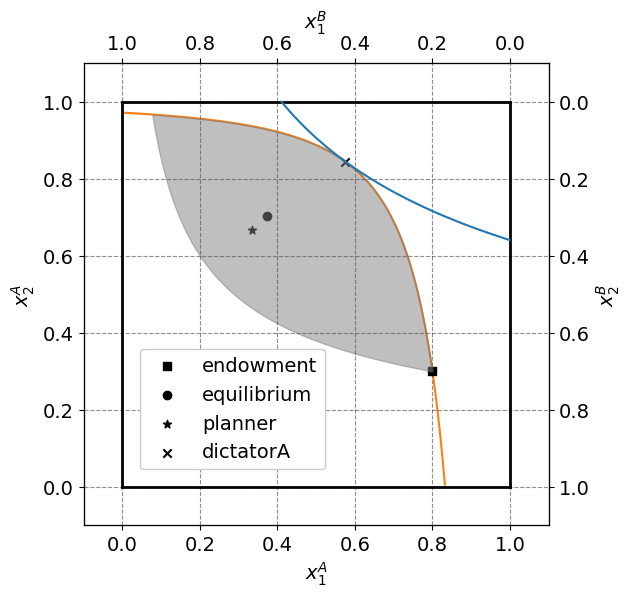

In [15]:
fig,ax_A,ax_B = model.create_edgeworthbox()

ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')
ax_A.scatter(sol.xA[0],sol.xA[1],marker='o',color='black',label='equilibrium')
ax_A.scatter(sol.xA_planner[0],sol.xA_planner[1],marker='*',color='black',label='planner')
ax_A.scatter(sol.xA_dictatorA[0],sol.xA_dictatorA[1],marker='x',color='black',label='dictatorA')

model.indifference_curve_A(ax_A,sol.xA_dictatorA[0],sol.xA_dictatorA[1],color=colors[0])
model.indifference_curve_B(ax_B,1-sol.xA_dictatorA[0],1-sol.xA_dictatorA[1],color=colors[1])
model.plot_improvement_set(ax_A)
model.add_legend(ax_A,ax_B)

## 7. <a id='toc7_'></a>[Random endowments](#toc0_)

Assume endowments are $\omega\sim\mathcal{U}(0,1)$.

In [16]:
model.draw_random_endowments()

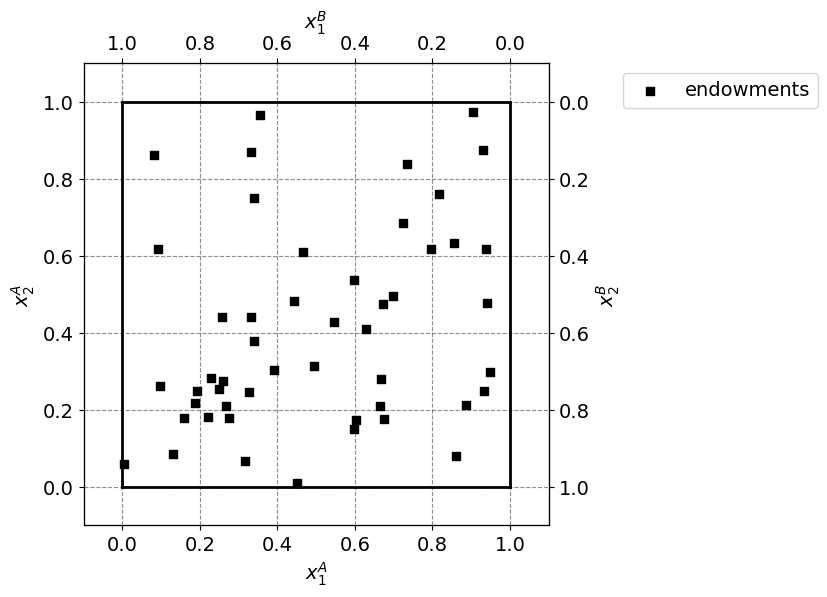

In [17]:
fig,ax_A,ax_B = model.create_edgeworthbox()
ax_A.scatter(sim.WA[0,:],sim.WA[1,:],marker='s',color='black',label='endowments')
ax_A.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.6,1.0));

What is the Walras equilibrium for each endowment?

In [18]:
model.solve_random_endowments()

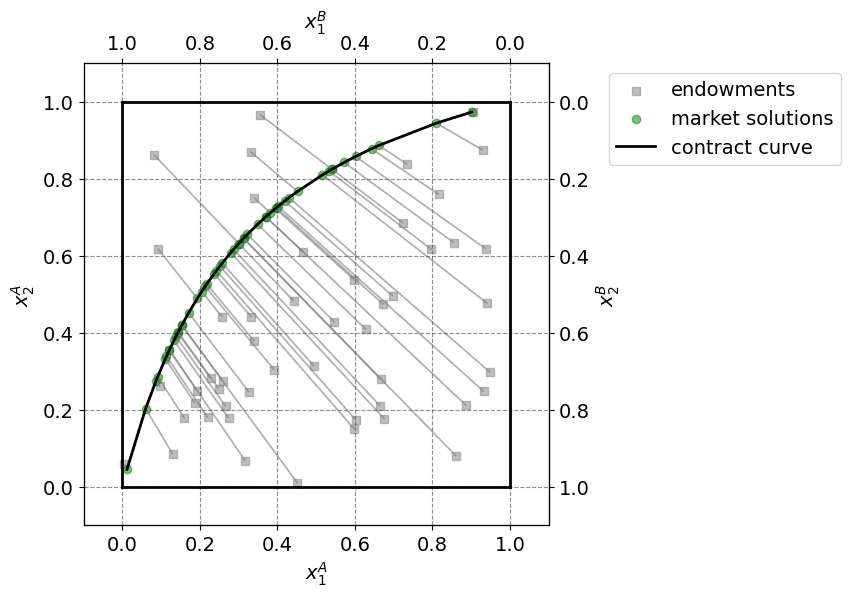

In [19]:
fig,ax_A,ax_B = model.create_edgeworthbox()

# a. endowment solution
ax_A.scatter(sim.WA[0,:],sim.WA[1,:],marker='s',color='grey',alpha=0.5,label='endowments')
ax_A.scatter(sim.xA[0,:],sim.xA[1,:],marker='o',color='green',alpha=0.5,label='market solutions')

for i in range(sim.WA.shape[1]):
    ax_A.arrow(sim.WA[0,i],sim.WA[1,i],sim.xA[0,i]-sim.WA[0,i],sim.xA[1,i]-sim.WA[1,i],color='grey',alpha=0.5)

# b. contract curve
I = np.argsort(sim.xA[0,:])
ax_A.plot(sim.xA[0,I],sim.xA[1,I],color='black',lw=2,label='contract curve')

# c. legend
ax_A.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.65,1.0));

## 8. <a id='toc8_'></a>[Any final questions?](#toc0_)

**Socrative room:** PROGECON